# Лабораторная работа 2. Классификация текстов на основе вхождения в документ словарных слов

**Задание 1.** Загрузите в датафрейм новостной датасет `lenta_ru_news_filtered.csv`, собранный на базе корпуса `lenta.ru v1.0`. В датасете каждая новость описывается следующими полями:
* **url** - адрес новости на сайте `lenta.ru`,
* **topic** - тема новости,
* **title** - заголовок новости,
* **text** - текст новости.

Ответьте на следуюшие вопросы:
1. Сколько всего новостных текстов?
2. На какие темы встречаются новости?
3. Сколько новостных текстов в каждой теме?

In [1]:
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix
from tqdm import tqdm  # для прогресс-бара

In [2]:
# Загрузка датасета
df = pd.read_csv('lenta_ru_news_filtered.csv')
df.head()

,Unnamed: 0,url,topic,title,text
0,34,https://lenta.ru/news/2018/12/15/putinrap/,Культура,Путин предостерег от запретов рэп-концертов,"Президент России Владимир Путин, выступая на з..."
1,52,https://lenta.ru/news/2018/12/15/cirk/,Культура,Путин пообещал поразбираться с Cirque du Solei...,Владимир Путин пообещал разобраться с открытие...
2,53,https://lenta.ru/news/2018/12/15/asomov/,Культура,Умер актер «Кривого зеркала»,В Ташкенте скончался участник юмористической т...
3,57,https://lenta.ru/news/2018/12/14/zinchuk/,Культура,Зинчук рассказал подробности аварии и призвал ...,"Гитарист-виртуоз и композитор Виктор Зинчук, г..."
4,63,https://lenta.ru/news/2018/12/14/bydlo/,Культура,За сравнившего с быдлом зрителей актера «Униве...,"Коллеги актера Андрея Гайдуляна, известного по..."


In [3]:
# 1. Сколько всего новостных текстов?
total_news = len(df)
print(f"1. Всего новостных текстов: {total_news}")

# 2. На какие темы встречаются новости?
unique_topics = df['topic'].unique()
print(f"\n2. Уникальные темы новостей ({len(unique_topics)} тем):")
for i, topic in enumerate(sorted(unique_topics), 1):
    print(f"   {i}. {topic}")

# 3. Сколько новостных текстов в каждой теме?
news_per_topic = df['topic'].value_counts()
print(f"\n3. Количество новостей по темам:")
print(news_per_topic)

1. Всего новостных текстов: 4000

2. Уникальные темы новостей (2 тем):
   1. Культура
   2. Экономика

3. Количество новостей по темам:
topic
Культура     2000
Экономика    2000
Name: count, dtype: int64


**Задание 2.** Выполните предобработку новостных текстов в виде:
- приведение к нижнему регистру,
- удаление знаков пунктуации.

**(!) Далее в лабораторной работе задания выполняются с полученными обработанными текстами**.

Разделите датасет на обучающую и тестовую части в соотношении 80% к 20%. Выведите диаграммы, отражающие количество текстов по каждой теме в каждой из частей.

In [4]:
# Функция для предобработки текста
def preprocess_text(text):

    # Приведение к нижнему регистру
    text = text.lower()

    # Удаление знаков пунктуации
    # Сохраняем дефисы только внутри слов (между буквами)
    # Удаляем все остальные знаки пунктуации

    # Шаг 1: Заменяем дефисы внутри слов на специальный маркер
    text = re.sub(r'(\w)-(\w)', r'\1HYPHENMARKER\2', text)

    # Шаг 2: Удаляем всю пунктуацию
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Шаг 3: Восстанавливаем дефисы
    text = text.replace('HYPHENMARKER', '-')

    # Шаг 4: Удаляем одиночные дефисы, которые остались
    text = re.sub(r'\s*-\s*', ' ', text)
    text = re.sub(r'^\s*-\s*', '', text)
    text = re.sub(r'\s*-\s*$', '', text)

    # Шаг 5: Удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [5]:
# Предобработка заголовков
df['title_clean'] = df['title'].apply(preprocess_text)

# Предобработка текстов новостей
df['text_clean'] = df['text'].apply(preprocess_text)

df.head()

,Unnamed: 0,url,topic,title,text,title_clean,text_clean
0,34,https://lenta.ru/news/2018/12/15/putinrap/,Культура,Путин предостерег от запретов рэп-концертов,"Президент России Владимир Путин, выступая на з...",путин предостерег от запретов рэп концертов,президент россии владимир путин выступая на за...
1,52,https://lenta.ru/news/2018/12/15/cirk/,Культура,Путин пообещал поразбираться с Cirque du Solei...,Владимир Путин пообещал разобраться с открытие...,путин пообещал поразбираться с cirque du solei...,владимир путин пообещал разобраться с открытие...
2,53,https://lenta.ru/news/2018/12/15/asomov/,Культура,Умер актер «Кривого зеркала»,В Ташкенте скончался участник юмористической т...,умер актер «кривого зеркала»,в ташкенте скончался участник юмористической т...
3,57,https://lenta.ru/news/2018/12/14/zinchuk/,Культура,Зинчук рассказал подробности аварии и призвал ...,"Гитарист-виртуоз и композитор Виктор Зинчук, г...",зинчук рассказал подробности аварии и призвал ...,гитарист виртуоз и композитор виктор зинчук го...
4,63,https://lenta.ru/news/2018/12/14/bydlo/,Культура,За сравнившего с быдлом зрителей актера «Униве...,"Коллеги актера Андрея Гайдуляна, известного по...",за сравнившего с быдлом зрителей актера «униве...,коллеги актера андрея гайдуляна известного по ...


In [6]:
# Информация о результате
print(f"\nИнформация о датафрейме после предобработки:")
print(f"Всего записей: {len(df)}")
print(f"Колонки: {list(df.columns)}")

# Проверка на наличие пустых текстов после очистки
empty_texts = df[df['text_clean'].str.strip() == '']
print(f"Пустых текстов после очистки: {len(empty_texts)}")


Информация о датафрейме после предобработки:
Всего записей: 4000
Колонки: ['Unnamed: 0', 'url', 'topic', 'title', 'text', 'title_clean', 'text_clean']
Пустых текстов после очистки: 0


In [7]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('topic', axis=1),
    df['topic'],
    test_size=0.2,
    random_state=42,
    stratify=df['topic']
)

# Создаем датафреймы для каждой выборки
train_df = X_train.copy()
train_df['topic'] = y_train

test_df = X_test.copy()
test_df['topic'] = y_test

# Подсчет количества текстов по темам для каждой выборки
train_topic_counts = train_df['topic'].value_counts().sort_index()
test_topic_counts = test_df['topic'].value_counts().sort_index()

In [26]:
train_df.head()

,Unnamed: 0,url,title,text,title_clean,text_clean,topic,text_lemmatized
3719,17116,https://lenta.ru/news/2018/08/01/petro_top/,Порошенко потребовал от России денег,Президент Украины Петр Порошенко потребовал от...,порошенко потребовал от россии денег,президент украины петр порошенко потребовал от...,Экономика,президент украина петр порошенко потребовать о...
358,4422,https://lenta.ru/news/2018/11/13/solov/,Кинотеатр «Соловей» превратят в ЖК,Киноцентр «Соловей» на Красной Пресне перестро...,кинотеатр «соловей» превратят в жк,киноцентр «соловей» на красной пресне перестро...,Культура,киноцентр « соловей » на красный пресня перест...
490,6324,https://lenta.ru/news/2018/10/28/67/,Умерла актриса и телеведущая Марина Ливанова,"Актриса театра и кино, телеведущая Марина Лива...",умерла актриса и телеведущая марина ливанова,актриса театра и кино телеведущая марина ливан...,Культура,актриса театр и кино телеведущий марина ливано...
3844,18405,https://lenta.ru/news/2018/07/20/poehavshiy/,США поставили Китаю ультиматум,Президент США Дональд Трамп в интервью телекан...,сша поставили китаю ультиматум,президент сша дональд трамп в интервью телекан...,Экономика,президент сша дональд трамп в интервью телекан...
1427,22621,https://lenta.ru/news/2018/06/15/peggg/,Звезда «Зомби по имени Шон» оказался алкоголиком,Британский актер и сценарист Саймон Пегг призн...,звезда «зомби по имени шон» оказался алкоголиком,британский актер и сценарист саймон пегг призн...,Культура,британский актер и сценарист саймон пегг призн...


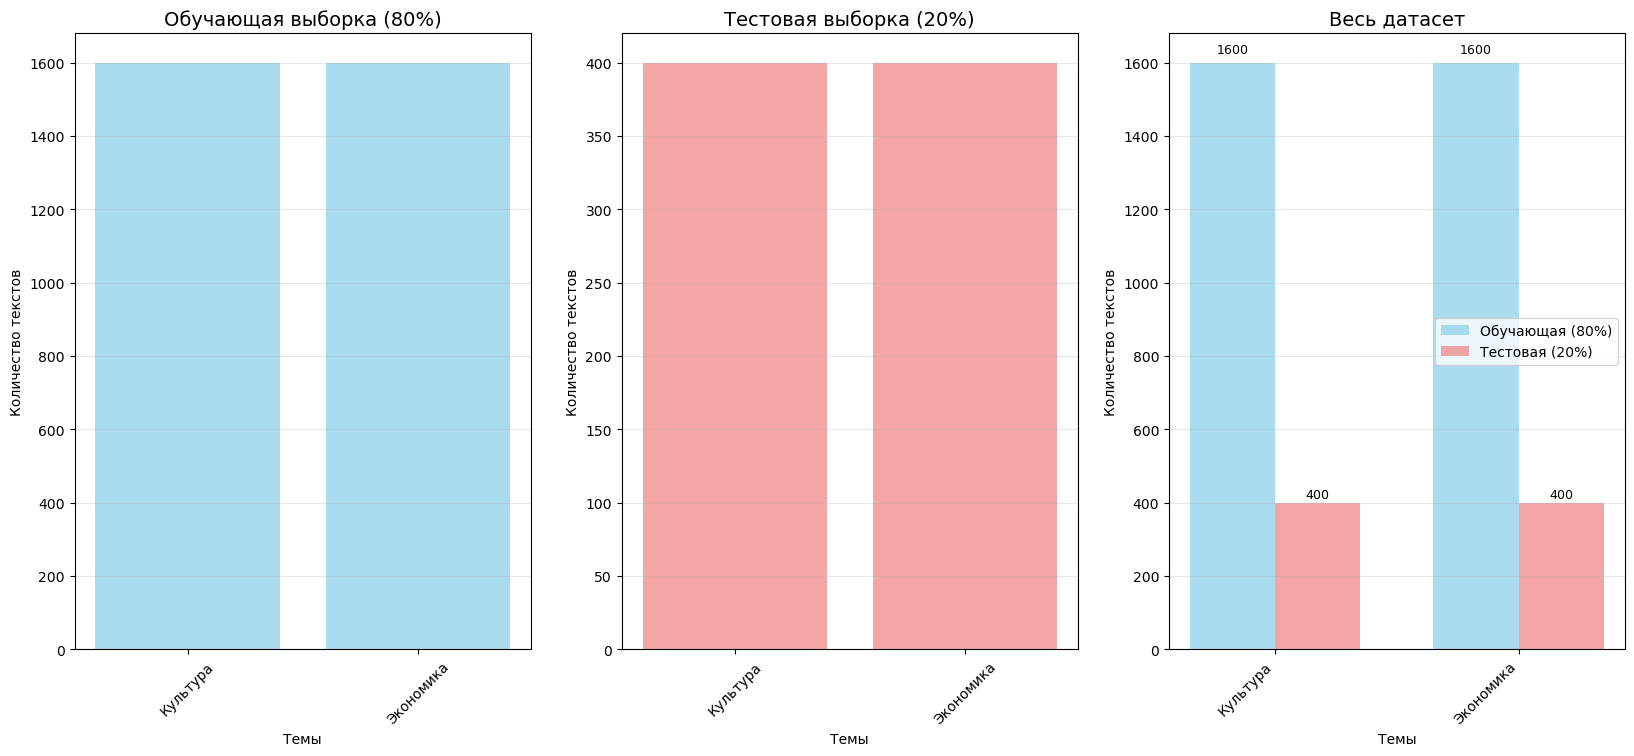

In [8]:
# Построение графиков
plt.figure(figsize=(20, 8))

# Обучающая выборка
plt.subplot(1, 3, 1)
plt.bar(train_topic_counts.index, train_topic_counts.values, alpha=0.7, color='skyblue')
plt.title('Обучающая выборка (80%)', fontsize=14)
plt.xlabel('Темы')
plt.ylabel('Количество текстов')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Тестовая выборка
plt.subplot(1, 3, 2)
plt.bar(test_topic_counts.index, test_topic_counts.values, alpha=0.7, color='lightcoral')
plt.title('Тестовая выборка (20%)', fontsize=14)
plt.xlabel('Темы')
plt.ylabel('Количество текстов')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Весь датасет
plt.subplot(1, 3, 3)
x = np.arange(len(train_topic_counts))
width = 0.35  # Ширина столбцов

plt.bar(x - width/2, train_topic_counts.values, width,
        label='Обучающая (80%)', alpha=0.7, color='skyblue')
plt.bar(x + width/2, test_topic_counts.values, width,
        label='Тестовая (20%)', alpha=0.7, color='lightcoral')

plt.title('Весь датасет', fontsize=14)
plt.xlabel('Темы')
plt.ylabel('Количество текстов')
plt.xticks(x, train_topic_counts.index, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Добавление значений на столбцы
for i, v in enumerate(train_topic_counts.values):
    plt.text(i - width/2, v + max(train_topic_counts.values)*0.01, str(v),
             ha='center', va='bottom', fontsize=9)
for i, v in enumerate(test_topic_counts.values):
    plt.text(i + width/2, v + max(test_topic_counts.values)*0.01, str(v),
             ha='center', va='bottom', fontsize=9)

plt.show()

**Задание 3.** Подсчитайте частоту встречаемости слов предобработанных новостных текстов `обучающей` части датафрейма. Какие слова употребляются наиболее часто вцелом в этих новостных текстах, а какие слова употребляются в этих же новостных текстах относительно тем (выведите топ-`50` слов для каждого случая)?

Нахождение частот слов в новостных текстах датафрейма можно выполнять посредством инструмента `FreqDist` библиотеки `NLTK`.

Например:
```
df['text'].apply(lambda x: nltk.FreqDist(nltk.word_tokenize(x)))
```

In [9]:
nltk.download('punkt_tab')
# Частоты слов для каждого текста
freq_dists = df['text_clean'].apply(lambda x: nltk.FreqDist(nltk.word_tokenize(x)).most_common(10))

print("top-10 наиболее часто встречающихся слов для каждого текста:")
print(freq_dists)
for i, freq_dist in enumerate(freq_dists.head()): #для первых пяти текстов
    print(f"Текст {i}: {dict(freq_dist)}")

[nltk_data] Downloading package punkt_tab to /home/demon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


top-10 наиболее часто встречающихся слов для каждого текста:
0       [(и, 8), (в, 6), («, 5), (», 5), (на, 4), (пут...
1       [(в, 9), (на, 9), («, 6), (», 6), (—, 6), (и, ...
2       [(в, 11), (», 7), («, 6), (обид, 3), (асомов, ...
3       [(в, 9), (на, 5), (что, 5), («, 4), (», 4), (и...
4       [(«, 12), (», 12), (в, 12), (и, 7), (что, 6), ...
                              ...                        
3995    [(в, 16), (на, 11), (и, 10), (с, 8), (о, 8), (...
3996    [(в, 5), («, 4), (», 4), (и, 4), (с, 3), (увз,...
3997    [(в, 6), («, 4), (2, 4), (», 4), (украины, 3),...
3998    [(в, 9), (и, 6), (с, 4), (банк, 3), (россии, 3...
3999    [(до, 5), (на, 4), (в, 4), (водку, 3), (от, 3)...
Name: text_clean, Length: 4000, dtype: object
Текст 0: {'и': 8, 'в': 6, '«': 5, '»': 5, 'на': 4, 'путин': 3, 'культуре': 3, 'концертов': 3, '—': 3, 'что': 3}
Текст 1: {'в': 9, 'на': 9, '«': 6, '»': 6, '—': 6, 'и': 5, 'не': 5, 'с': 4, 'cirque': 4, 'du': 4}
Текст 2: {'в': 11, '»': 7, '«': 6, 'обид': 3,

In [10]:
# Подсчет частоты слов для всей обучающей выборки
print("Подсчет частоты слов для всей обучающей выборки...")

# Создаем общий список всех слов из всех текстов
all_words = []
for text in train_df['text_clean']:
    tokens = word_tokenize(text)
    all_words.extend(tokens)

# Создаем частотное распределение
freq_dist_all = FreqDist(all_words)

# Топ-50 самых частых слов в целом
print("\n" + "="*60)
print("top-50 самых частых слов во всех текстах:")
print("="*60)
top_50_all = freq_dist_all.most_common(50)
for i, (word, freq) in enumerate(top_50_all, 1):
    print(f"{i:2d}. {word:<15} {freq:>6} раз")

# Подсчет частоты слов по темам
print("\n" + "="*60)
print("top-50 самых частых слов по темам:")
print("="*60)

# Словарь для хранения частотных распределений по темам
topic_freq_dists = {}

for topic in train_df['topic'].unique():
    print(f"\n--- Тема: {topic} ---")

    # Фильтруем тексты по теме
    topic_texts = train_df[train_df['topic'] == topic]['text_clean']

    # Собираем все слова для данной темы
    topic_words = []
    for text in topic_texts:
        tokens = word_tokenize(text)
        topic_words.extend(tokens)

    # Создаем частотное распределение для темы
    topic_freq = FreqDist(topic_words)
    topic_freq_dists[topic] = topic_freq

    # Топ-50 слов для данной темы
    top_50_topic = topic_freq.most_common(50)
    for i, (word, freq) in enumerate(top_50_topic, 1):
        print(f"{i:2d}. {word:<15} {freq:>6} раз")

Подсчет частоты слов для всей обучающей выборки...

top-50 самых частых слов во всех текстах:
 1. в                26047 раз
 2. «                14440 раз
 3. »                14423 раз
 4. и                13203 раз
 5. на               11881 раз
 6. что               6759 раз
 7. —                 6647 раз
 8. с                 5880 раз
 9. по                5702 раз
10. не                4476 раз
11. за                3249 раз
12. из                3214 раз
13. он                2561 раз
14. этом              2438 раз
15. о                 2423 раз
16. года              2396 раз
17. для               2202 раз
18. к                 2070 раз
19. россии            2057 раз
20. как               2044 раз
21. об                2012 раз
22. его               2001 раз
23. также             1977 раз
24. это               1915 раз
25. а                 1880 раз
26. году              1612 раз
27. от                1600 раз
28. до                1526 раз
29. рублей            1285 раз
30. про

**Задание 4.** Составьте словари из текстов `обучающей` части датасетов наболее часто встречающихся слов, которые встречаются **только в одной из каждых тем**. Постройте диаграмму для топ-`50` этих слов для каждой темы (ось X - слова, ось Y - частоты встречаемости слов в новостных текстах).

In [11]:
def freq_dicts(column):# Создаем частотные распределения для каждой темы
    print("Создание частотных распределений по темам...")
    topic_freq_dists = {}
    topic_words = {}

    for topic in train_df['topic'].unique():
        topic_texts = train_df[train_df['topic'] == topic][column]

        # Собираем все слова для темы
        words = []
        for text in topic_texts:
            tokens = word_tokenize(text)
            words.extend(tokens)

        topic_freq_dists[topic] = FreqDist(words)
        topic_words[topic] = set(words)  # уникальные слова темы

    # Находим слова, уникальные для каждой темы
    print("Поиск уникальных слов для каждой темы...")
    unique_topic_words = {}

    for topic in train_df['topic'].unique():
        # Слова текущей темы
        current_topic_words = topic_words[topic]

        # Слова всех других тем
        other_topics_words = set()
        for other_topic in train_df['topic'].unique():
            if other_topic != topic:
                other_topics_words.update(topic_words[other_topic])

        # Слова, которые есть только в этой теме
        unique_words = current_topic_words - other_topics_words
        unique_topic_words[topic] = unique_words

        print(f"{topic}: {len(unique_words)} уникальных слов")

    # Создаем словари уникальных слов с частотами
    print("\nСоздание словарей уникальных слов...")
    unique_word_dicts = {}

    for topic in train_df['topic'].unique():
        topic_freq = topic_freq_dists[topic]
        unique_words = unique_topic_words[topic]

        # Создаем словарь {слово: частота} только для уникальных слов
        unique_dict = {word: topic_freq[word] for word in unique_words if word in topic_freq}

        # Сортируем по убыванию частоты и берем топ-50
        top_50_unique = dict(sorted(unique_dict.items(), key=lambda x: x[1], reverse=True)[:50])
        unique_word_dicts[topic] = top_50_unique
        print(unique_word_dicts[topic])
        print(f"{topic}: {len(top_50_unique)} слов в топ-50")

    return unique_word_dicts

In [12]:
unique_word_dicts = freq_dicts('text_clean')

Создание частотных распределений по темам...
Поиск уникальных слов для каждой темы...
Экономика: 26140 уникальных слов
Культура: 25831 уникальных слов

Создание словарей уникальных слов...
{'цен': 348, 'нефть': 217, 'роста': 207, 'цб': 199, 'мсп': 187, 'триллиона': 165, 'товаров': 154, 'ввп': 147, 'валюты': 147, 'роснефти': 145, 'тонн': 143, 'акций': 136, 'опек': 132, 'добычи': 130, 'втб': 125, 'роснефть': 123, 'баррелей': 120, 'пошлины': 115, 'строительства': 113, 'топлива': 113, 'bloomberg': 108, 'повышения': 107, 'ндс': 104, 'банков': 101, 'товары': 96, 'мер': 92, 'газопровода': 92, 'ставки': 87, 'экономика': 87, 'стоимости': 86, 'поставки': 86, 'бензина': 84, 'активов': 84, 'баррель': 83, 'торговой': 83, 'выросли': 82, 'доллар': 82, 'пошлин': 81, 'минфин': 81, 'минэкономразвития': 78, 'газпрома': 76, 'добычу': 75, 'субъектов': 75, '2024': 75, 'предприятий': 75, 'предложения': 74, 'инфраструктуры': 74, 'инвестиций': 72, 'спг': 72, 'банки': 72}
Экономика: 50 слов в топ-50
{'актриса':

In [13]:
# Построение диаграмм
def paint_hist(unique_word_dicts):
    i = 1
    for topic in train_df['topic'].unique():
        # Сортируем словарь по частоте (если еще не отсортирован)
        sorted_words = sorted(unique_word_dicts[topic].items(), key=lambda x: x[1], reverse=True)
        words, frequencies = zip(*sorted_words)

        # Построение диаграммы
        plt.figure(figsize=(20, 10))
        y_pos = np.arange(len(words))

        bars = plt.barh(y_pos, frequencies, color='skyblue', alpha=0.7, edgecolor='navy', linewidth=0.5)

        plt.yticks(y_pos, words, fontsize=10)
        plt.xlabel('Частота встречаемости', fontsize=12, fontweight='bold')
        plt.title(f'Топ-50 самых частых слов в теме {topic}\n(слово-частота)',
                  fontsize=14, fontweight='bold', pad=20)

        # Добавляем значения на столбцы
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(width + max(frequencies)*0.01, bar.get_y() + bar.get_height()/2,
                     f'{int(width)}', ha='left', va='center', fontsize=9, fontweight='bold')

        plt.gca().invert_yaxis()  # Самые частые слова сверху
        plt.grid(axis='x', alpha=0.3, linestyle='--')
        plt.tight_layout()
        i =+ 1

        plt.show()

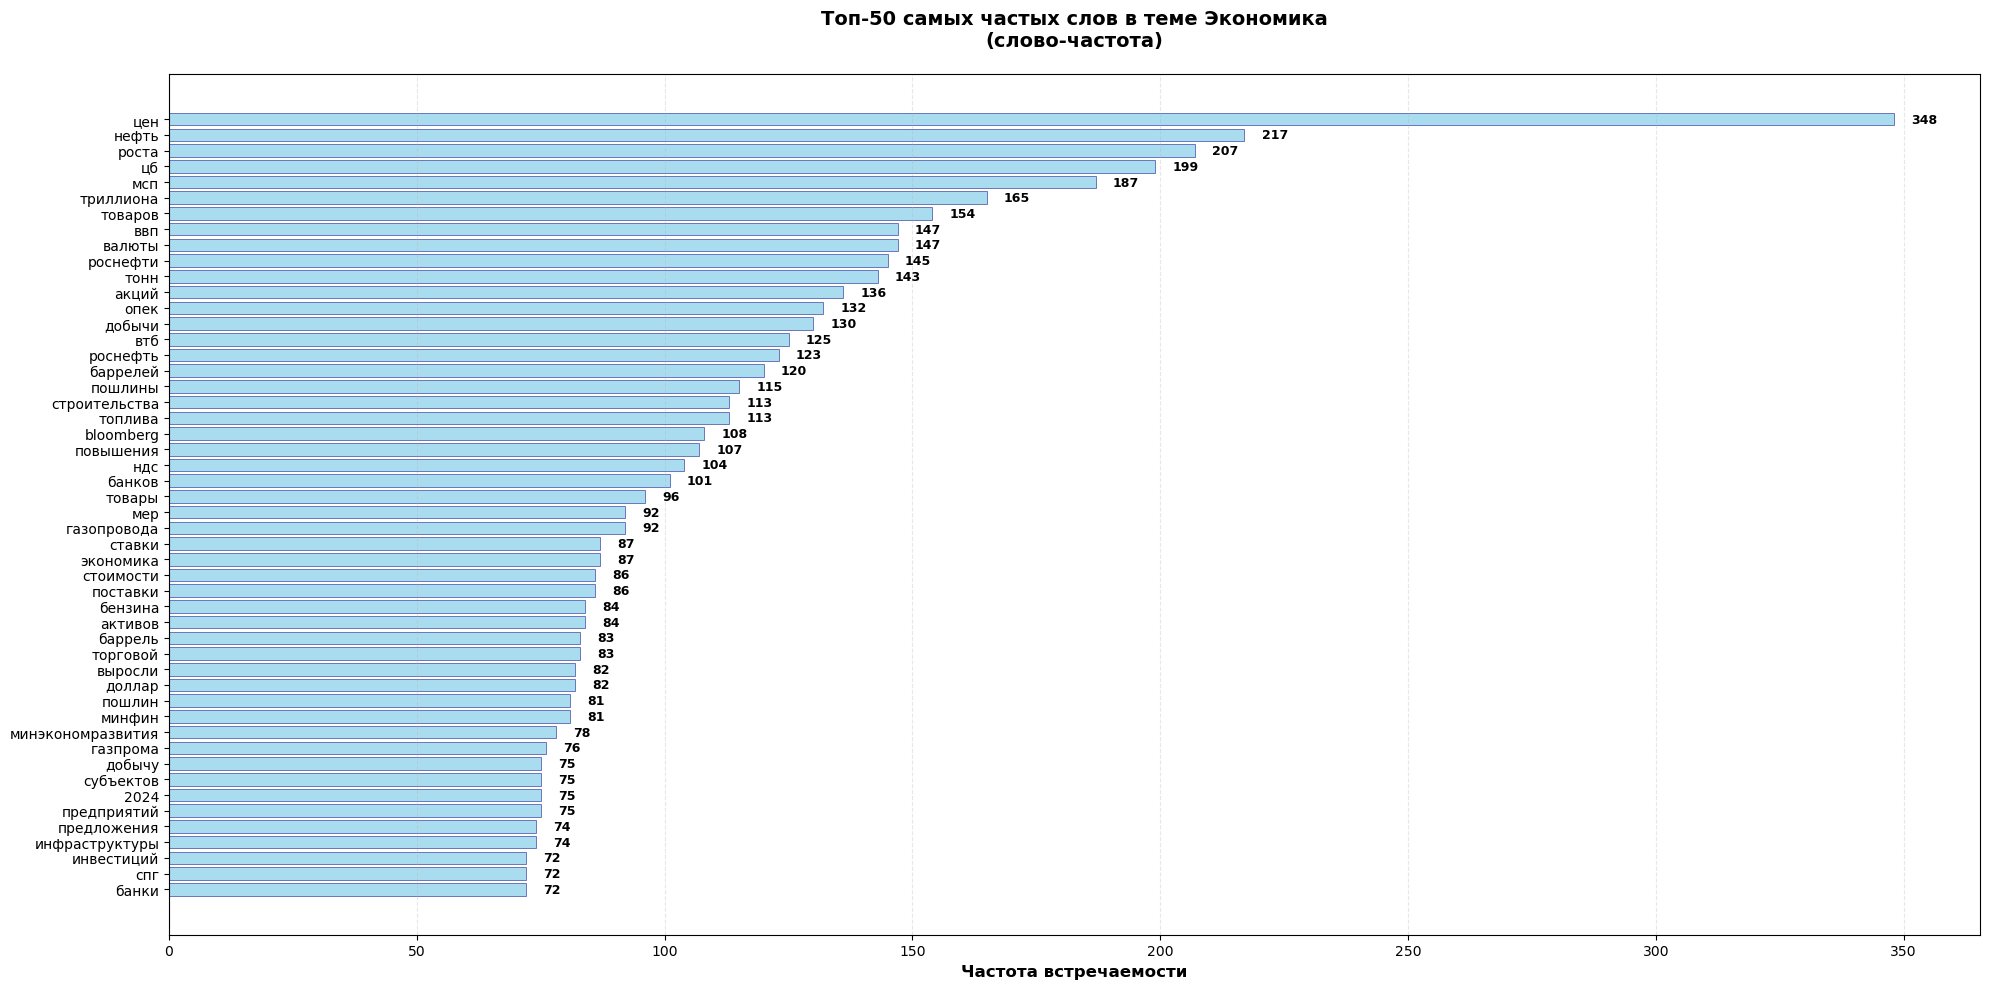

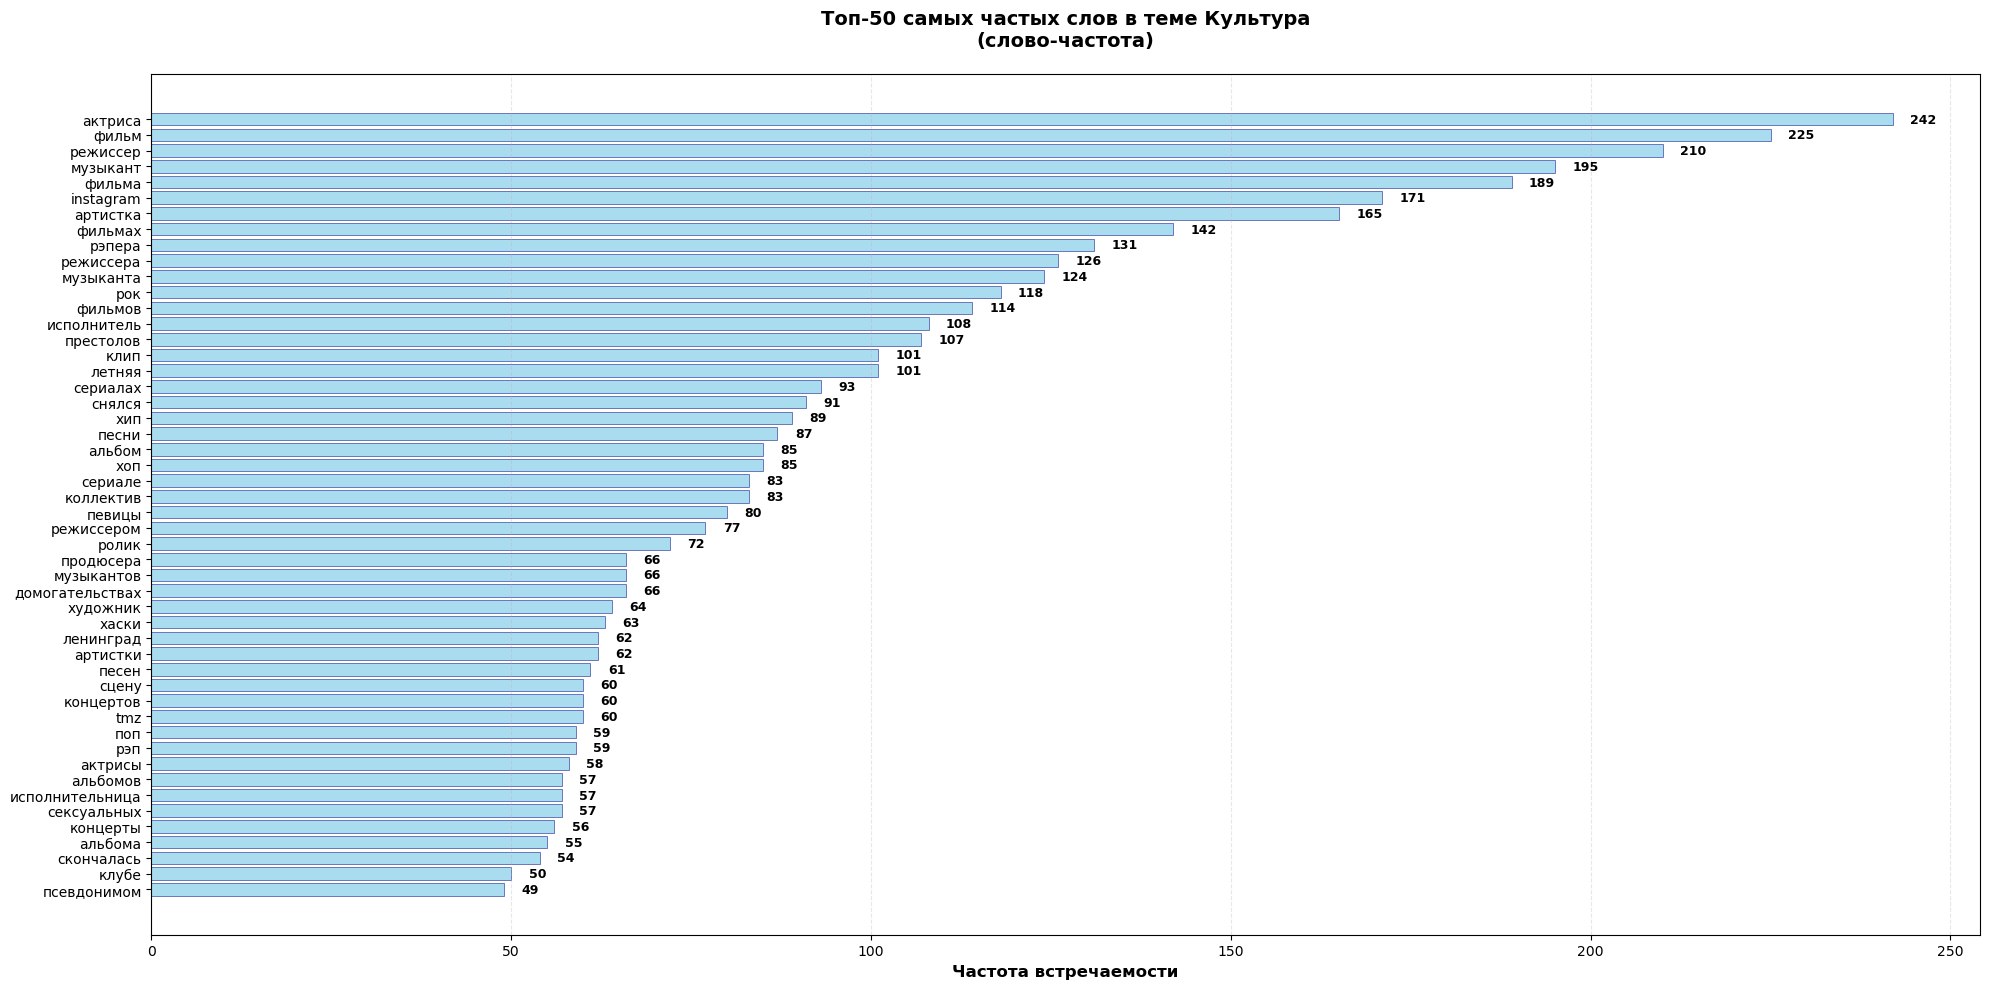

In [14]:
paint_hist(unique_word_dicts)

**Задание 5.** Выполните классификацию новостных текстов из `тестовой` части датасета на основе `top-k слов` (`k` - как входной параметр) из словарей, построенных в задании `4` на основе `обучающей` части датасета. Оцените показатели `полнота` и `точность` классификации (относительно значения параметра `k`) при указании количества документов, для которых не получилось определить тему.

Общий алгоритм классификации:

- Для документа `x` считаем сколько встречается слов, из словаря каждой из тем.
- Выбираем тему для документа `x` с максимальным количеством слов
- Отдельно обрабатываем случаи, когда количество слов одинаковое или равно 0. Это случаи, когда не получилось определить тему документа.

In [15]:
# Функция создания словарей слов для каждой темы (на основе обучающей части)
def create_dictionaries(train_df, column):

    topic_dicts = {}
    topic_freq_dists = {}

    for topic in train_df['topic'].unique():
        # Собираем все слова для темы
        topic_texts = train_df[train_df['topic'] == topic][column]
        all_words = []

        for text in topic_texts:
            tokens = word_tokenize(text)
            all_words.extend(tokens)

        # Создаем частотное распределение
        freq_dist = FreqDist(all_words)
        topic_freq_dists[topic] = freq_dist
        topic_dicts[topic] = set([word for word, freq in freq_dist.most_common()])

    return topic_dicts, topic_freq_dists

# Функция классификации документа
def classify_text(text, topic_dicts):
    tokens = set(word_tokenize(text))
    scores = {}

    for topic, topic_words in topic_dicts.items():
        # Подсчет совпадающих слов
        common_words = tokens.intersection(topic_words)
        scores[topic] = len(common_words)

    # Находим тему с максимальным счетом
    if not scores or max(scores.values()) == 0:
        return 'unknown'  # Не удалось определить тему

    max_score = max(scores.values())
    best_topics = [topic for topic, score in scores.items() if score == max_score]

    # Если несколько тем с одинаковым счетом - не определяем тему
    if len(best_topics) > 1:
        return 'unknown'

    return best_topics[0]

In [16]:
def classify(train_df, test_df, topic_dicts, topic_freq_dists, column, k_values=range(10, 301, 10)):

    results = []

    for k in k_values:
        print(f"Обработка k = {k}...")
        # Создаем словари для текущего k
        topic_dicts = {}

        for topic in train_df['topic'].unique():
            top_k_words = [word for word, freq in topic_freq_dists[topic].most_common(k)]
            topic_dicts[topic] = set(top_k_words)

        # Классифицируем тестовые документы
        true_labels = []
        pred_labels = []

        for idx, row in test_df.iterrows():
            true_topic = row['topic']
            pred_topic = classify_text(row[column], topic_dicts)

            true_labels.append(true_topic)
            pred_labels.append(pred_topic)

        # Подсчитываем метрики
        total_docs = len(test_df) # Всего
        unknown_docs = pred_labels.count('unknown') # Не распознанных
        known_docs = total_docs - unknown_docs # Распознанных

        # Для вычисления precision и recall учитываем только документы с определенной темой
        known_true = []
        known_pred = []
        for i, pred in enumerate(pred_labels):
            if pred != 'unknown':
                known_true.append(true_labels[i])
                known_pred.append(pred)

        if known_docs > 0:
            precision = precision_score(known_true, known_pred, average='weighted', zero_division=0)
            recall = recall_score(known_true, known_pred, average='weighted', zero_division=0)
            accuracy = np.mean(np.array(known_true) == np.array(known_pred))
        else:
            precision = recall = accuracy = 0

        results.append({
            'k': k,
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy,
            'total_docs': total_docs,
            'unknown_docs': unknown_docs,
            'known_docs': known_docs,
            'unknown_ratio': unknown_docs / total_docs
        })

    return pd.DataFrame(results)

In [17]:
# Создаем словари
topic_dicts, topic_freq_dists = create_dictionaries(train_df, 'text_clean')
# Классифицируем
results_df = classify(train_df, test_df, topic_dicts, topic_freq_dists, 'text_clean', k_values=range(50, 451, 50))
results_df

Обработка k = 50...
Обработка k = 100...
Обработка k = 150...
Обработка k = 200...
Обработка k = 250...
Обработка k = 300...
Обработка k = 350...
Обработка k = 400...
Обработка k = 450...


,k,precision,recall,accuracy,total_docs,unknown_docs,known_docs,unknown_ratio
0,50,0.835819,0.835616,0.835616,800,70,730,0.08750
1,100,0.932860,0.930574,0.930574,800,51,749,0.06375
2,150,0.945361,0.945013,0.945013,800,18,782,0.02250
3,200,0.954073,0.953787,0.953787,800,21,779,0.02625
4,250,0.967183,0.966879,0.966879,800,15,785,0.01875
5,300,0.968300,0.968153,0.968153,800,15,785,0.01875
6,350,0.974727,0.974716,0.974716,800,9,791,0.01125
7,400,0.977215,0.977215,0.977215,800,10,790,0.01250
8,450,0.978616,0.978589,0.978589,800,6,794,0.00750


**Задание 6.** Познакомьтесь с библиотекой Natasha для обработки текстов на русском языке, прочитав <a href="https://habr.com/ru/articles/516098/">статью</a>.

#### Импорт библиотек и создание объекта для работы с текстом
Импортируйте библиотеки для сегментации на предложения, морфологического и синтаксического анализа.

```python
from natasha import(
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    Doc,
)
```

Создайте объект из обрабатываемого текста `text`:

```python
text_doc = Doc(text)
```

In [18]:
from natasha import(
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    Doc,
)

In [19]:
text_doc = Doc(text)
print(text_doc)

Doc(text='объявлен лауреат гонкуровской премии — самой прес...)


#### Сегментация на предложения
Создайте объект, который будет выполнять сегментацию текста на предложения:

```python
segmenter = Segmenter()
```

С помощью сегментатора можно разбить текст на предложения и токены:

```python
text_doc.segment(segmenter)
print(text_doc.tokens)
print(text_doc.sents)
```

In [20]:
segmenter = Segmenter()
text_doc.segment(segmenter)
print(text_doc.tokens)
print(text_doc.sents)

[DocToken(stop=8, text='объявлен'), DocToken(start=9, stop=16, text='лауреат'), DocToken(start=17, stop=29, text='гонкуровской'), DocToken(start=30, stop=36, text='премии'), DocToken(start=37, stop=38, text='—'), DocToken(start=39, stop=44, text='самой'), DocToken(start=45, stop=55, text='престижной'), DocToken(start=56, stop=67, text='французской'), DocToken(start=68, stop=80, text='литературной'), DocToken(start=81, stop=88, text='награды'), DocToken(start=89, stop=91, text='за'), DocToken(start=92, stop=97, text='роман'), DocToken(start=98, stop=100, text='об'), DocToken(start=101, stop=105, text='этом'), DocToken(start=106, stop=107, text='в'), DocToken(start=108, stop=113, text='среду'), DocToken(start=114, stop=115, text='7'), DocToken(start=116, stop=122, text='ноября'), DocToken(start=123, stop=131, text='сообщает'), DocToken(start=132, stop=138, text='france'), DocToken(start=139, stop=143, text='info'), DocToken(start=144, stop=155, text='обладателем'), DocToken(start=156, st

#### Морфологический анализ

Инициализируйте словарь и морфологический анализатор:
```python
morph_vocab = MorphVocab()
morph_tagger = NewsMorphTagger(emb)
```

Чтобы получить морфологическую разметку слова `word` воспользуйтесь:

```python
morph_vocab.parse(word)
```

Добавить морфологическую разметку к объекту обрабатываемого текста (Doc) можно как

```python
text_doc.tag_morph(morph_tagger)
print(text_doc.tokens)
text_doc.sents[0].morph.print()
```

Получить леммы текста можно через метод `lemmatize`:

```python
for token in text_doc.tokens:
    token.lemmatize(morph_vocab)
{_.text: _.lemma for _ in text_doc.tokens}
```

In [21]:
'''
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

morph_vocab.parse(word)
text_doc.segment(segmenter)
text_doc.tag_morph(morph_tagger)
print('========== Вывод токенов ===========')
print(text_doc.tokens)
print('\n========== Более удобный формат вывода ===========')
text_doc.sents[0].morph.print()
for token in text_doc.tokens:
    token.lemmatize(morph_vocab)
print('\n========== Вывод лемм ===========')
{_.text: _.lemma for _ in text_doc.tokens}

'''
# Инициализация всех компонентов
segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
morph_vocab = MorphVocab()

# Создание документа и поэтапная обработка
text = "Последовательность действий для лемматизации с помощью ,библиотеки natasha"
text_doc = Doc(text) # Сначала создаем объект из обрабатываемого текста
text_doc.segment(segmenter)  # Затем сегментируем на токены
text_doc.tag_morph(morph_tagger)  # Затем морфологический разбор
#print(text_doc.tokens)

# Лемматизация для каждого токена
for token in text_doc.tokens:
    token.lemmatize(morph_vocab)

# Вывод результатов
print("Токены с леммами:")
for token in text_doc.tokens:
    print(f"{token.text} -> {token.lemma}")

print(f"\nВсе леммы: {[token.lemma for token in text_doc.tokens]}")


/home/demon/.local/lib/python3.13/site-packages/pymorphy2/analyzer.py:114: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Токены с леммами:
Последовательность -> последовательность
действий -> действие
для -> для
лемматизации -> лемматизация
с -> с
помощью -> помощь
, -> ,
библиотеки -> библиотека
natasha -> natasha

Все леммы: ['последовательность', 'действие', 'для', 'лемматизация', 'с', 'помощь', ',', 'библиотека', 'natasha']


**Задание 7.** Добавьте столбец в обучающую и тестовую часть датасета с обработанными текстами после лемматизации.

In [22]:
def lemmatize_text(text, segmenter, morph_vocab, emb, MorphTagger, Doc):

    # Создаем документ
    doc = Doc(str(text))

    # Сегментируем на токены
    doc.segment(segmenter)
    if not doc.tokens:
        return ""

    # Морфологический разбор
    morph_tagger = MorphTagger(emb)
    doc.tag_morph(morph_tagger)

    # Лемматизация
    lemmas = []
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
        lemmas.append(token.lemma.lower())

    return " ".join(lemmas)

def add_lemmatized_column(df, column_name='text_clean', new_column_name='text_lemmatized', batch_size=1000):

    # Инициализация всех компонентов
    segmenter = Segmenter()
    emb = NewsEmbedding()
    MorphTagger = NewsMorphTagger
    morph_vocab = MorphVocab()

    if segmenter is None:
        print("Не удалось инициализировать Natasha. Возвращаю исходный датафрейм.")
        df[new_column_name] = df[column_name]
        return df

    print(f"Начинаю лемматизацию {len(df)} текстов...")

    # Обрабатываем тексты партиями для экономии памяти
    lemmatized_texts = []

    for i in tqdm(range(0, len(df), batch_size)):
        batch = df.iloc[i:i + batch_size]
        batch_texts = []

        for text in batch[column_name]:
            lemmatized = lemmatize_text(text, segmenter, morph_vocab, emb, MorphTagger, Doc)
            batch_texts.append(lemmatized)

        lemmatized_texts.extend(batch_texts)

    # Добавляем новый столбец
    df[new_column_name] = lemmatized_texts

    # Статистика
    empty_lemmas = df[new_column_name].str.strip().eq('').sum()
    print(f"Лемматизация завершена!")
    print(f"Пустых текстов после лемматизации: {empty_lemmas}")
    print(f"Пример обработанного текста:")
    print(f"Оригинал: {df[column_name].iloc[0][:100]}...")
    print(f"Леммы: {df[new_column_name].iloc[0][:100]}...")

    return df

In [23]:
add_lemmatized_column(train_df, column_name='text_clean', new_column_name='text_lemmatized', batch_size=100)
add_lemmatized_column(test_df, column_name='text_clean', new_column_name='text_lemmatized', batch_size=100)
test_df

Начинаю лемматизацию 3200 текстов...


100%|██████████| 32/32 [09:30<00:00, 17.84s/it]


Лемматизация завершена!
Пустых текстов после лемматизации: 0
Пример обработанного текста:
Оригинал: президент украины петр порошенко потребовал от россии компенсацию за разрушение экономического потен...
Леммы: президент украина петр порошенко потребовать от россия компенсация за разрушение экономический потен...
Начинаю лемматизацию 800 текстов...


100%|██████████| 8/8 [02:18<00:00, 17.35s/it]

Лемматизация завершена!
Пустых текстов после лемматизации: 0
Пример обработанного текста:
Оригинал: опережающее восстановление добычи в рамках опек и инициативы нацеленные на рост капитализации превра...
Леммы: опережать восстановление добыча в рамка опек и инициатива нацелить на рост капитализация превратить ...


,Unnamed: 0,url,title,text,title_clean,text_clean,topic,text_lemmatized
3743,17340,https://lenta.ru/news/2018/07/30/rosneft_fokus/,«Роснефть» оказалась в фокусе рынка,Опережающее восстановление добычи в рамках ОПЕ...,«роснефть» оказалась в фокусе рынка,опережающее восстановление добычи в рамках опе...,Экономика,опережать восстановление добыча в рамка опек и...
2725,7203,https://lenta.ru/news/2018/10/20/4mlrd/,Украина получит от МВФ почти 4 миллиарда долларов,Международный валютный фонд (МВФ) и власти Укр...,украина получит от мвф почти 4 миллиарда долларов,международный валютный фонд мвф и власти украи...,Экономика,международный валютный фонд мвф и власть украи...
1014,15558,https://lenta.ru/news/2018/08/14/cage/,Австралиец 14 часов смотрел фильмы с Николасом...,Австралийский кинокритик Люк Бакмастер посетил...,австралиец 14 часов смотрел фильмы с николасом...,австралийский кинокритик люк бакмастер посетил...,Культура,австралийский кинокритик люк бакмастер посетит...
3381,13984,https://lenta.ru/news/2018/08/28/shmalio/,Названы главные условия для роста российской э...,Развитие бизнеса в России тормозят отсутствие ...,названы главные условия для роста российской э...,развитие бизнеса в россии тормозят отсутствие ...,Экономика,развитие бизнес в россия тормозить отсутствие ...
3307,13324,https://lenta.ru/news/2018/09/03/benzin_again/,В России снова начал дорожать бензин,На московских автозаправочных станциях (АЗС) в...,в россии снова начал дорожать бензин,на московских автозаправочных станциях азс впе...,Экономика,на московский автозаправочный станция азс впер...
...,...,...,...,...,...,...,...,...
3809,18014,https://lenta.ru/news/2018/07/24/nastroenie_uh...,Экономика России провернула негативный маневр,Российская экономика вернулась в зону недостат...,экономика россии провернула негативный маневр,российская экономика вернулась в зону недостат...,Экономика,российский экономика вернуться в зона недостат...
26,339,https://lenta.ru/news/2018/12/13/insanegot/,Поклонникам «Игры престолов» пообещали проблем...,"Актриса Гвендолин Кристи, исполняющая роль Бри...",поклонникам «игры престолов» пообещали проблем...,актриса гвендолин кристи исполняющая роль брие...,Культура,актриса гвендолина кристи исполнять роль бриен...
1823,28548,https://lenta.ru/news/2018/04/24/nothingsacred/,Суд разрешил выставить на торги интимные письм...,Певице Мадонне не удалось пресечь продажу на а...,суд разрешил выставить на торги интимные письм...,певице мадонне не удалось пресечь продажу на а...,Культура,певица мадонна не удаться пресечь продажа на а...
1122,17328,https://lenta.ru/news/2018/07/30/chechenfilm/,Полиция возбудила дело о мошенничестве на студ...,МВД России возбудило уголовное дело о мошеннич...,полиция возбудила дело о мошенничестве на студ...,мвд россии возбудило уголовное дело о мошеннич...,Культура,мвд россия возбудить уголовный дело о мошеннич...


**Задание 8.** Составьте словари на основе текстов `обучающей` части датасета по аналогии с **заданием 4.**, но с текстами, полученными после лемматзации.

Создание частотных распределений по темам...
Поиск уникальных слов для каждой темы...
Экономика: 10182 уникальных слов
Культура: 13562 уникальных слов

Создание словарей уникальных слов...
{'роснефть': 279, 'пошлина': 253, 'добыча': 253, 'поставка': 246, 'ставка': 231, 'триллион': 224, 'баррель': 219, 'цб': 199, 'мсп': 187, 'минфин': 173, 'нефтяной': 172, 'кредит': 169, 'тонна': 164, 'ввп': 147, 'биржа': 145, 'выплата': 131, 'инвестиция': 129, 'газопровод': 127, 'втб': 125, 'опек': 123, 'потребитель': 118, 'инвестиционный': 117, 'инфраструктура': 115, 'мощность': 113, 'bloomberg': 108, 'ндс': 104, 'нафтогаз': 101, 'импорт': 98, 'инфляция': 97, 'темп': 96, 'кудрин': 92, 'банковский': 91, 'пенсионер': 86, 'акциз': 86, 'превышать': 86, 'акционер': 82, 'дефицит': 79, 'минэкономразвития': 78, 'механизм': 77, 'месторождение': 76, 'транзит': 75, '2024': 75, 'стратегия': 74, 'спг': 72, 'нефтепродукт': 71, 'работодатель': 71, 'холдинг': 71, '2021': 71, 'самозанятой': 70, 'кубометр': 66}
Экономи

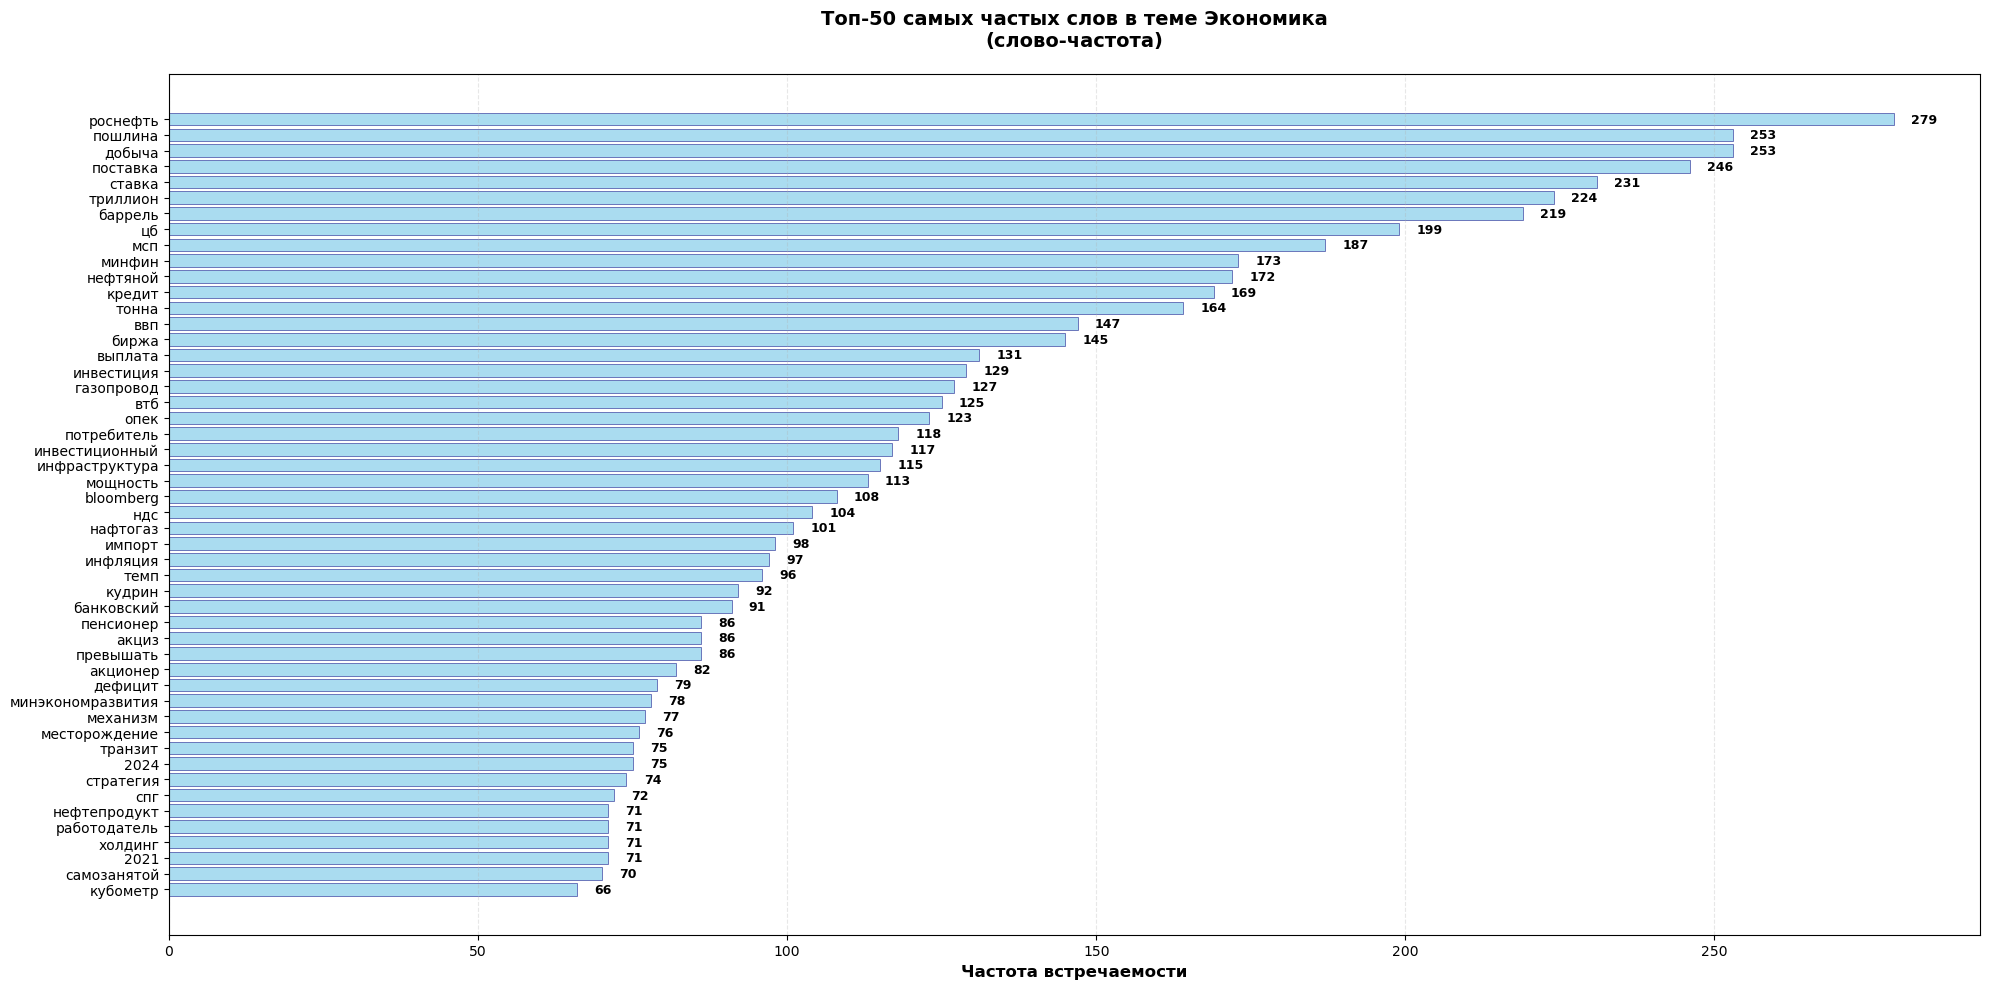

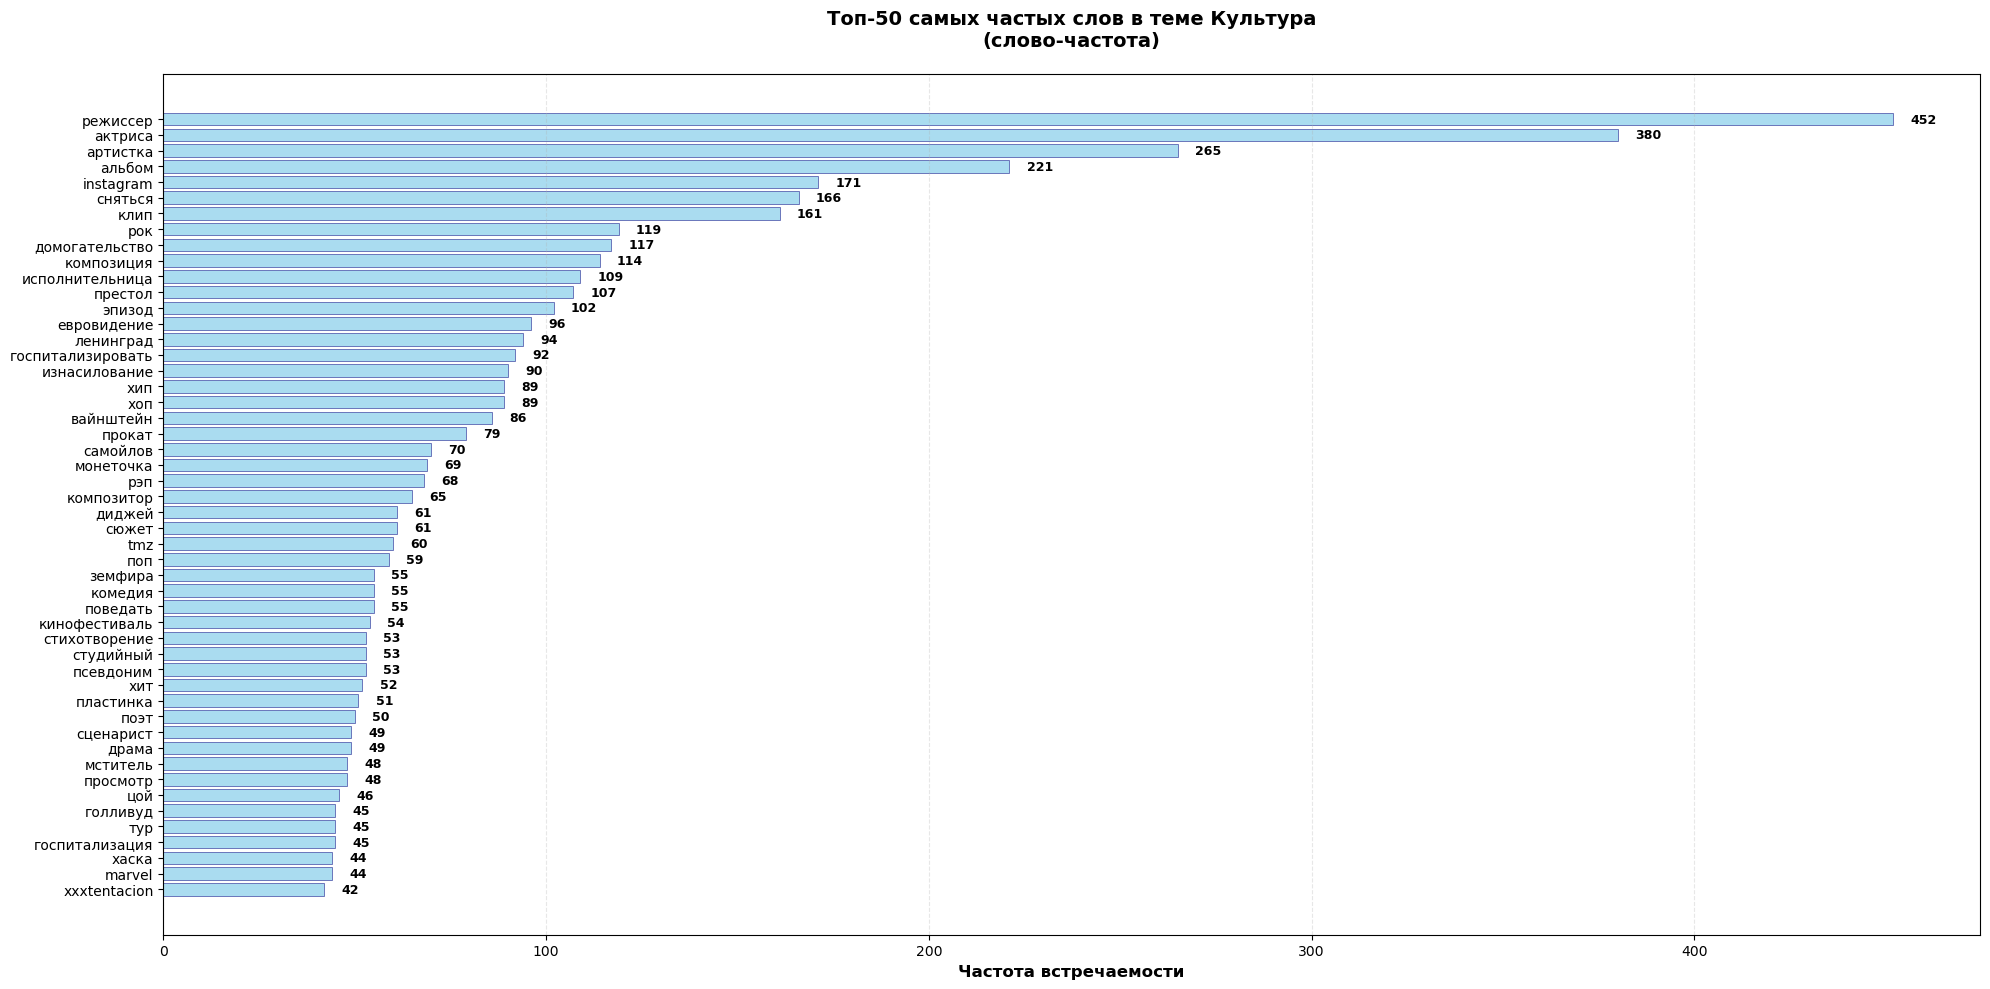

In [24]:
unique_word_dicts_after_lemmatized = freq_dicts('text_lemmatized')
paint_hist(unique_word_dicts_after_lemmatized)

**Задание 9.** Сделайте классификацию новостных текстов `тестовой` части датасета по аналогии с **заданием 5.**, но с текстами, полученными **после лемматзации**.

In [25]:
# Создаем словари
topic_dicts_after_lemmatized, topic_freq_dists_after_lemmatized = create_dictionaries(train_df, 'text_lemmatized')
# Классифицируем
results_df_after_lemmatized = classify(train_df, test_df, topic_dicts, topic_freq_dists, 'text_lemmatized', k_values=range(50, 451, 50))
results_df_after_lemmatized

Обработка k = 50...
Обработка k = 100...
Обработка k = 150...
Обработка k = 200...
Обработка k = 250...
Обработка k = 300...
Обработка k = 350...
Обработка k = 400...
Обработка k = 450...


,k,precision,recall,accuracy,total_docs,unknown_docs,known_docs,unknown_ratio
0,50,0.812983,0.812693,0.812693,800,154,646,0.19250
1,100,0.906938,0.899032,0.899032,800,77,723,0.09625
2,150,0.929251,0.926129,0.926129,800,69,731,0.08625
3,200,0.923218,0.923077,0.923077,800,59,741,0.07375
4,250,0.935916,0.935780,0.935780,800,37,763,0.04625
5,300,0.948119,0.948119,0.948119,800,29,771,0.03625
6,350,0.964424,0.964377,0.964377,800,14,786,0.01750
7,400,0.964056,0.964010,0.964010,800,22,778,0.02750
8,450,0.967056,0.966624,0.966624,800,21,779,0.02625
